In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import time
import scipy.io as sc
from sklearn.metrics import mean_squared_error, r2_score


# code is taken from this resource: https://www.youtube.com/watch?v=c0k-YLQGKjY
# and modified to suit my own dataset

/var/folders/48/_wqpm7x9659b0t_zqycj5z200000gn/T/ipykernel_11749/321381744.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


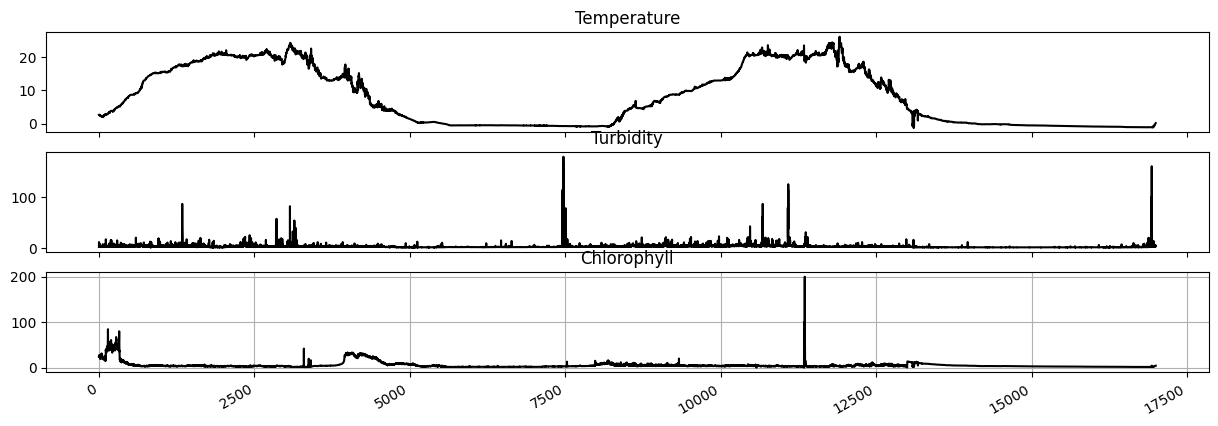

(16997, 4)


In [84]:
# download the data
f = sc.loadmat('data_new.mat')
vals = f['data_new'][0,0]
keys = f['data_new'][0,0].dtype.descr
f['data_new'][0,0]["Y"].shape

data = {}
for i in range(len(keys)-1):
    key = keys[i][0]
    data[str(key)] = vals[key]

datafrm = {"Temperature": data["X"][0,:].reshape(-1), "Turbidity": data["X"][1,:].reshape(-1), "Chlorophyll": data["X"][2,:].reshape(-1), "TargetChlorophyll": data["Y"].reshape(-1)}
data = pd.DataFrame(data=datafrm)

# visualize the data
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.subplot(3,1,1)
plt.plot(data["Temperature"],c='black')
plt.title("Temperature")

plt.subplot(3,1,2)
plt.plot(data["Turbidity"],c='black')
plt.title("Turbidity")

plt.subplot(3,1,3)
plt.plot(data["Chlorophyll"],c='black')
plt.title("Chlorophyll")

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()
print(data.shape)

/var/folders/48/_wqpm7x9659b0t_zqycj5z200000gn/T/ipykernel_11749/240068689.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


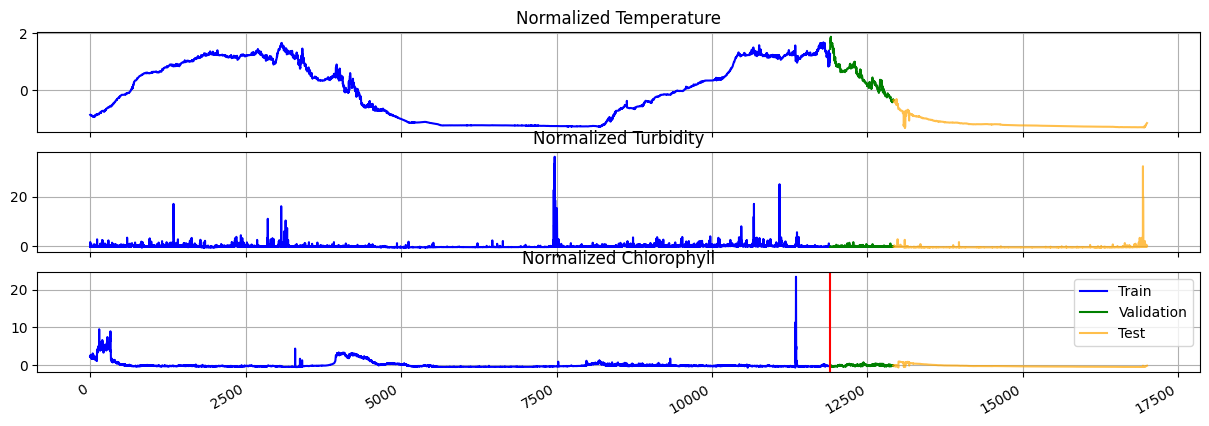

In [85]:

# split the data into train and test partitions, use 70% first samples as test data and rest as train data
Tp = 11900 # ≈70%
Tv = 1020 # ≈20% of the remaining
values = data.values.astype(np.float32)
train,test = values[0:Tp,:], values[Tp:,:]

# normalize the data, use train set normalization for test set
scaler = preprocessing.StandardScaler()
train_scaler = scaler.fit(train)
data_norm = train_scaler.transform(values).reshape(-1,4)

#data_norm = pd.DataFrame(data_norm, columns=["Value"])
# visualize the data again with test and training samples separated
index = data.index.values

plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=500))
plt.subplot(3,1,1)
plt.plot(index[0:Tp],data_norm[:Tp,0],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,0],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,0],c='orange',alpha=0.7)
plt.title("Normalized Temperature")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(index[0:Tp],data_norm[:Tp,1],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,1],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,1],c='orange',alpha=0.7)
plt.title("Normalized Turbidity")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(index[0:Tp],data_norm[:Tp,2],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,2],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,2],c='orange',alpha=0.7)
plt.legend(['Train','Validation', 'Test'])
plt.axvline(data.index[Tp], c="r")
plt.title("Normalized Chlorophyll")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()


In [86]:
# sliding window
def df_to_X_y(df, window_size=5):
  #print(df.shape)
  X = []
  y = []
  # if wanted to use all but the closing time to predict closing time
  xindex = [0,1,2]
  Xdata= df[:,xindex]
  print(Xdata.shape)
  Ydata = df[:,3]
  print(Ydata.shape)
  for i in range(len(df)-window_size):
    row = [[a] for a in Xdata[i:i+window_size]]
    X.append(row)
    label = Ydata[i+window_size-1]
    y.append(label)
  return np.array(X), np.array(y)


WINDOW_SIZE = 20
X, y = df_to_X_y(data_norm, WINDOW_SIZE)
print(X.shape, y.shape)

X_train, y_train = X[:Tp].squeeze(), y[:Tp]
X_val, y_val = X[Tp:Tp+Tv].squeeze(), y[Tp:Tp+Tv]
X_test, y_test = X[Tp+Tv:].squeeze(), y[Tp+Tv:]

print(X_train.shape, y_train.shape)


(16997, 3)
(16997,)
(16977, 20, 1, 3) (16977,)
(11900, 20, 3) (11900,)


In [87]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.InputLayer((WINDOW_SIZE, X_train.shape[2])))
lstm_model.add(tf.keras.layers.LSTM(64))
lstm_model.add(tf.keras.layers.Dense(8, 'relu'))
lstm_model.add(tf.keras.layers.Dense(1, 'linear'))


cp = ModelCheckpoint('lstm_model/', save_best_only=True)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError()])

start = time.time()
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[cp])
end = time.time()
print("Training time " + str(end-start))

lstm_model = load_model('lstm_model/')


Epoch 1/25
363/372 [============================>.] - ETA: 0s - loss: 0.4004 - mean_absolute_error: 0.2878INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 3s 7ms/step - loss: 0.3929 - mean_absolute_error: 0.2848 - val_loss: 0.0191 - val_mean_absolute_error: 0.1027
Epoch 2/25
362/372 [============================>.] - ETA: 0s - loss: 0.1364 - mean_absolute_error: 0.1239INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.1331 - mean_absolute_error: 0.1228 - val_loss: 0.0168 - val_mean_absolute_error: 0.0969
Epoch 3/25
371/372 [============================>.] - ETA: 0s - loss: 0.1063 - mean_absolute_error: 0.0871INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.1061 - mean_absolute_error: 0.0871 - val_loss: 0.0155 - val_mean_absolute_error: 0.0919
Epoch 4/25
365/372 [============================>.] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.0737INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.0975 - mean_absolute_error: 0.0747 - val_loss: 0.0141 - val_mean_absolute_error: 0.0870
Epoch 5/25
366/372 [============================>.] - ETA: 0s - loss: 0.0927 - mean_absolute_error: 0.0706INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.0915 - mean_absolute_error: 0.0704 - val_loss: 0.0139 - val_mean_absolute_error: 0.0851
Epoch 6/25
372/372 [==============================] - ETA: 0s - loss: 0.0863 - mean_absolute_error: 0.0667INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 3s 7ms/step - loss: 0.0863 - mean_absolute_error: 0.0667 - val_loss: 0.0134 - val_mean_absolute_error: 0.0833
Epoch 7/25
367/372 [============================>.] - ETA: 0s - loss: 0.0840 - mean_absolute_error: 0.0648INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.0830 - mean_absolute_error: 0.0647 - val_loss: 0.0131 - val_mean_absolute_error: 0.0820
Epoch 8/25
369/372 [============================>.] - ETA: 0s - loss: 0.0798 - mean_absolute_error: 0.0641INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.0796 - mean_absolute_error: 0.0642 - val_loss: 0.0125 - val_mean_absolute_error: 0.0797
Epoch 9/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0771 - mean_absolute_error: 0.0621 - val_loss: 0.0129 - val_mean_absolute_error: 0.0808
Epoch 10/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0748 - mean_absolute_error: 0.0610 - val_loss: 0.0126 - val_mean_absolute_error: 0.0803
Epoch 11/25
364/372 [============================>.] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.0613INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.0732 - mean_absolute_error: 0.0613 - val_loss: 0.0124 - val_mean_absolute_error: 0.0798
Epoch 12/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0716 - mean_absolute_error: 0.0603 - val_loss: 0.0135 - val_mean_absolute_error: 0.0835
Epoch 13/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0700 - mean_absolute_error: 0.0595 - val_loss: 0.0127 - val_mean_absolute_error: 0.0807
Epoch 14/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0686 - mean_absolute_error: 0.0590 - val_loss: 0.0135 - val_mean_absolute_error: 0.0828
Epoch 15/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0671 - mean_absolute_error: 0.0591 - val_loss: 0.0136 - val_mean_absolute_error: 0.0831
Epoch 16/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0664 - mean_absolute_error: 0.0591 - val_loss: 0.0128 - val_mean_absolute_error: 0.0803
Epoch 17/25
372/372 [=

INFO:tensorflow:Assets written to: lstm_model/assets


372/372 [==============================] - 2s 6ms/step - loss: 0.0612 - mean_absolute_error: 0.0589 - val_loss: 0.0123 - val_mean_absolute_error: 0.0790
Epoch 21/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0602 - mean_absolute_error: 0.0576 - val_loss: 0.0131 - val_mean_absolute_error: 0.0839
Epoch 22/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0594 - mean_absolute_error: 0.0583 - val_loss: 0.0125 - val_mean_absolute_error: 0.0798
Epoch 23/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0581 - mean_absolute_error: 0.0578 - val_loss: 0.0129 - val_mean_absolute_error: 0.0801
Epoch 24/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0571 - mean_absolute_error: 0.0570 - val_loss: 0.0131 - val_mean_absolute_error: 0.0810
Epoch 25/25
372/372 [==============================] - 1s 4ms/step - loss: 0.0579 - mean_absolute_error: 0.0579 - val_loss: 0.0129 - val_mean_absolute_error: 0.0799
Training time 45.49541

In [55]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17937 (70.07 KB)
Trainable params: 17937 (70.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:

validation_target = y_test
validation_predictions = []
last_x = X_train[-1,:,:]

testInd = 0
while len(validation_predictions) < len(validation_target):
  p = lstm_model.predict(last_x.reshape(1,20,3), verbose=1)[0,0]
  validation_predictions.append(p)
  last_x = np.roll(last_x, -1, axis=0)

  last_x[-1,0] = X_test[testInd,-1,0]
  last_x[-1,1] = X_test[testInd,-1,1]
  last_x[-1,2] = p
  testInd = testInd + 1




1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 10ms/step


In [97]:

# Evaluate the model
mse = mean_squared_error(validation_target, validation_predictions)
r2 = r2_score(validation_target, validation_predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.18031570315361023
R-squared: -1.058985167704387


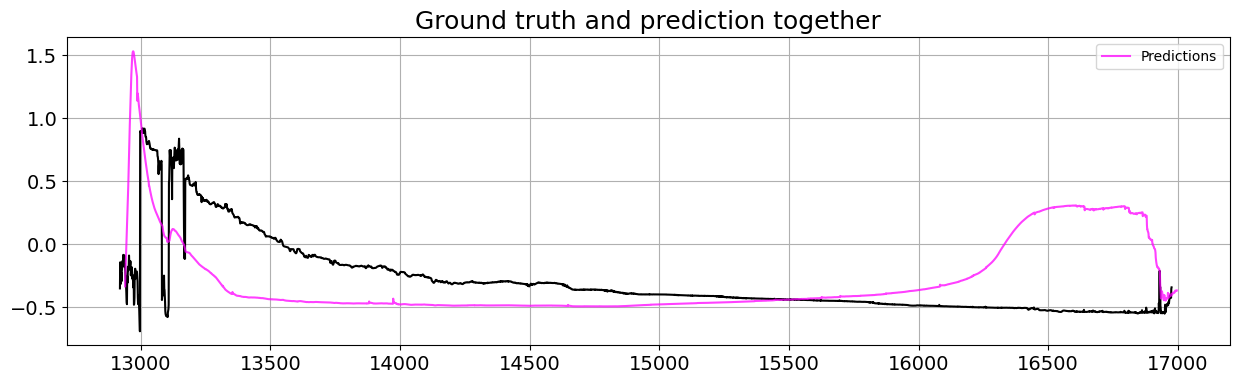

In [99]:
index = data.index.values
train_index = index[:Tp]
val_index = index[Tp:Tp+Tv]
test_index = index[Tp+Tv:-WINDOW_SIZE]

plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)

plt.plot(test_index, data_norm[test_index,-1],c='black')
#plt.plot(train_index+WINDOW_SIZE, train_results['Train Predictions'], c='orange',alpha=0.75)
#plt.plot(val_index+WINDOW_SIZE, val_results['Val Predictions'], c='blue',alpha=0.75)
plt.plot(test_index+WINDOW_SIZE, validation_predictions, c='magenta',alpha=0.75, label="Predictions")

plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
import visualkeras
model = lstm_model
visualkeras.layered_view(model).show()